In [1]:
from datetime import datetime
from ta import add_all_ta_features
import pandas as pd
import requests
import math
import numpy as np
from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

AV_KEY='5AK7ZPDAGCNO39B7'

In [4]:
STOCKS = ['500.PAR'] # ['500.PAR','IBM']
CRYPTOS = ['BTC','ETH']
LABEL_SYMBOL = '500.PAR'
DIFFS = {1:3, 5:3, 20:3}
LABEL = 'close'
LOOK_AHEAD = ['open']
NAN_LIMIT = 100 #remove 
NO_SAMPLES = 500
TRAINING_RATIO = 0.5

In [5]:
TECHNICAL_COLS = ['volume_adi', 'volume_obv',
       'volume_cmf', 'volume_fi', 'volume_mfi', 'volume_em', 'volume_vpt',
       'volume_nvi', 'volume_vwap', 'volatility_atr', 'volatility_bbm',
       'volatility_bbh', 'volatility_bbl', 'volatility_bbw', 'volatility_bbp',
       'volatility_bbhi', 'volatility_bbli', 'volatility_kcc',
       'volatility_kch', 'volatility_kcl', 'volatility_kcw', 'volatility_kcp',
       'volatility_kchi', 'volatility_kcli', 'volatility_dcl',
       'volatility_dch', 'volatility_dcm', 'volatility_dcw', 'volatility_dcp',
       'volatility_ui', 'trend_macd', 'trend_macd_signal', 'trend_macd_diff',
       'trend_sma_fast', 'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_adx', 'trend_adx_pos', 'trend_adx_neg', 'trend_vortex_ind_pos',
       'trend_vortex_ind_neg', 'trend_vortex_ind_diff', 'trend_trix',
       'trend_mass_index', 'trend_cci', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_conv',
       'trend_ichimoku_base', 'trend_ichimoku_a', 'trend_ichimoku_b',
       'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'trend_aroon_up',
       'trend_aroon_down', 'trend_aroon_ind', 'trend_psar_up_indicator',
       'trend_psar_down_indicator', 'trend_stc', 'momentum_rsi',
       'momentum_stoch_rsi', 'momentum_stoch_rsi_k', 'momentum_stoch_rsi_d',
       'momentum_tsi', 'momentum_uo', 'momentum_stoch',
       'momentum_stoch_signal', 'momentum_wr', 'momentum_ao', 'momentum_kama',
       'momentum_roc', 'momentum_ppo', 'momentum_ppo_signal',
       'momentum_ppo_hist', 'others_dr', 'others_dlr', 'others_cr']

In [6]:
def GetStockPriceDF(symbol): 
    cols = ['open', 'high', 'low', 'close', 'volume']
    url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol='+symbol+'&outputsize=full&apikey='+AV_KEY
    print(url)
    r = requests.get(url)
    data = r.json()
    dic = data['Time Series (Daily)']
    df = pd.DataFrame.from_dict(dic, orient='index')
    df = df[['1. open', '2. high', '3. low', '4. close', '6. volume']]
    df = df.rename(columns={'1. open': 'open', '2. high': 'high', '3. low': 'low','4. close':'close', '6. volume':'volume'})
    df.index.name = 'date'
    df = df.sort_index(ascending = True)
    df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
    return df

def GetCryptoPriceDF(symbol): 
    cols = ['open', 'high', 'low', 'close', 'volume']
    url = 'https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol='+symbol+'&market=CNY&apikey='+AV_KEY
    print(url)
    r = requests.get(url)
    data = r.json()
    dic = data['Time Series (Digital Currency Daily)']
    df = pd.DataFrame.from_dict(dic, orient='index')
    df = df[['1a. open (CNY)', '2a. high (CNY)', '3a. low (CNY)', '4a. close (CNY)', '5. volume']]
    df = df.rename(columns={'1a. open (CNY)': 'open', '2a. high (CNY)': 'high', '3a. low (CNY)': 'low', '4a. close (CNY)': 'close', '5. volume':'volume'})
    df.index.name = 'date'
    df = df.sort_index(ascending = True)
    df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
    return df

def CalculateTechnicals(df, technical_cols):
    cols = ['open', 'high', 'low', 'close', 'volume']
    df = add_all_ta_features(df, open="open", high="high", low="low", close="close", volume="volume")
    df = df[technical_cols]
    return df

def SampleDataframe(df, date, no_samples):
    ind = df.index.get_loc(date)
    if ind-no_samples > 0:
        df = df.iloc[ind+1-no_samples:ind+1,:]
        return df
    return None

def DiffShift(df, columns, diffs):
    final_dfs = []
    for diff in diffs.keys():
        diff_df = pd.DataFrame()   
        for col in columns:
            if diff == 0:
                diff_df[col] = df[col]
            else:
                diff_df[col+'_D'+str(diff)] = df[col].rolling(window=diff+1).apply(lambda x: x.iloc[diff] - x.iloc[0])
        sampled_dfs = []
        for shift in diffs[diff]:
            sampled_df = diff_df.shift(periods=shift)
            sampled_df = sampled_df.add_suffix('_S'+str(shift))
            sampled_dfs.append(sampled_df)
        final_df = pd.concat(sampled_dfs, axis=1, join="inner")
        final_dfs.append(final_df)   
    pivot_df = pd.concat(final_dfs, axis=1, join="inner")
    return pivot_df

def CreateDataset(stocks, pivot_cols, pivots, peak_cols, technical_cols, label_symbol, label_col):
    full_res, label_df = [], None
    for symbol in STOCKS: 
        sym_dfs = []
        df = GetStockPriceDF(symbol)
        #print(df)
        sym_dfs.append(DiffShift(df, pivot_cols, pivots)) # pivot
        sym_dfs.append(DiffShift(df, peak_cols, {1:[0]})) # peak ahead
        technicals = CalculateTechnicals(df, technical_cols) # calculate technicals
        #print(technicals)
        sym_dfs.append(DiffShift(technicals, technical_cols, {0:[1]})) #shifted technicals
        sym_df = pd.concat(sym_dfs, axis=1, join="inner").add_prefix(symbol + '_') #combined symbol data
        full_res.append(sym_df)

        if symbol == label_symbol:
            label_df = DiffShift(df, [label_col], {1:[0]})
    full_res.append(label_df)
    return pd.concat(full_res, axis=1, join='inner')

In [7]:
stocks = ['500.PAR']
pivot_cols = ['open'] # ['open','high','low','close','volume']
pivots = {1:[1]} #{1:[1,2,3,4],5:[5,10,15]}

peak_cols = ['open']
technical_cols = ['volume_adi']

label_symbol = '500.PAR'
label_col = 'close'

df = CreateDataset(stocks, pivot_cols, pivots, peak_cols, technical_cols, label_symbol, label_col) 
print(df)

https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=500.PAR&outputsize=full&apikey=5AK7ZPDAGCNO39B7


C:\Users\shave\AppData\Roaming\Python\Python37\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\shave\AppData\Roaming\Python\Python37\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars


            500.PAR_open_D1_S1  500.PAR_open_D1_S0  500.PAR_volume_adi_S1  \
date                                                                        
2010-06-15                 NaN                 NaN                    NaN   
2010-06-16                 NaN              0.0600          -1.000000e+00   
2010-06-17              0.0600              0.0900           1.666667e+00   
2010-06-18              0.0900             -0.1200           6.666667e-01   
2010-06-21             -0.1200              0.1900           5.400067e+04   
...                        ...                 ...                    ...   
2021-11-22              0.3111              0.3594           9.979051e+06   
2021-11-23              0.3594             -0.4997           1.004181e+07   
2021-11-24             -0.4997              0.3054           1.003834e+07   
2021-11-25              0.3054              0.6551           1.005114e+07   
2021-11-26              0.6551             -1.8116           1.005048e+07   

C:\Users\shave\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
C:\Users\shave\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
C:\Users\shave\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


Model: MLPRegressor(hidden_layer_sizes=(5, 5, 5)), iteration: 0/5, train mse: 0.9767419802291014, Test mse: 0.8182429845971585
Model: MLPRegressor(hidden_layer_sizes=(5, 5, 5)), iteration: 1/5, train mse: 1.0890828636752157, Test mse: 0.9898513578316441
Model: MLPRegressor(hidden_layer_sizes=(5, 5, 5)), iteration: 2/5, train mse: 1.0283823033100115, Test mse: 0.8545900701608967
Model: MLPRegressor(hidden_layer_sizes=(5, 5, 5)), iteration: 3/5, train mse: 0.9833289145869554, Test mse: 0.8333352499227186
Model: MLPRegressor(hidden_layer_sizes=(5, 5, 5)), iteration: 4/5, train mse: 0.9842354950737735, Test mse: 0.826625527833208
Best model: MLPRegressor(hidden_layer_sizes=(5, 5, 5)), iteration: 0, best MSE: 0.8182429845971585


C:\Users\shave\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
C:\Users\shave\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


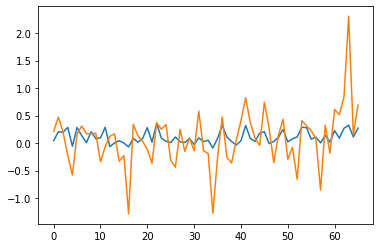

In [139]:
#meta model parameters
pca_comps = 2
models = [MLPRegressor(hidden_layer_sizes=(5,5,5))]
no_its = 5
no_samples = 200
test_size = 0.33

def Reverse_Scale(scaler, y, data_width):
    holder = np.zeros((y.shape[0], data_width))
    holder[:,-1] = y
    holder = scaler.inverse_transform(holder)
    return holder[:,-1]

def TrainForDate(df, date, no_samples, test_size, models, pca_comps, no_its):
    sampled_df = SampleDataframe(df, date, no_samples)
    data = sample.to_numpy()

    scaler = StandardScaler()
    scl_data = scaler.fit_transform(data)
    x, y = scl_data[:,:-1], scl_data[:,-1]

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=42)

    #fit pca on train, transform test
    pca = PCA(n_components=pca_comps)
    x_train = pca.fit_transform(x_train)
    x_test = pca.transform(x_test)

    best_model = None
    best_MSE = 100000000
    best_it = -1
    for model in models:
        for i in range(no_its):
            fitted_model = model.fit(x_train,y_train)
            y_train_pred = fitted_model.predict(x_train)
            y_test_pred = fitted_model.predict(x_test)

            mse_train = mean_squared_error(y_train, y_train_pred, squared=False)
            mse_test = mean_squared_error(y_test, y_test_pred, squared=False)
            print('Model: ' + str(model) + ', iteration: ' + str(i) + '/'+str(no_its) + ', train mse: ' + str(mse_train) + ', Test mse: ' + str(mse_test))
            if mse_test < best_MSE:
                best_model = fitted_model
                best_MSE = mse_test
                best_it = i
                
            #y_train_pred = best_model.predict(x_train)
            #y_test_pred = best_model.predict(x_test)
            #y_test_pred_oscale = Reverse_Scale(scaler, y_test_pred, data.shape[1])
            #y_test_acts_oscale = Reverse_Scale(scaler, y_test, data.shape[1])
            #plt.plot(y_test_pred_oscale, label = "predictions")
            #plt.plot(y_test_acts_oscale, label = "actual")
            #plt.show()
    
    y_train_pred = best_model.predict(x_train)
    y_test_pred = best_model.predict(x_test)
    y_test_pred_oscale = Reverse_Scale(scaler, y_test_pred, data.shape[1])
    y_test_acts_oscale = Reverse_Scale(scaler, y_test, data.shape[1])

    print('Best model: ' + str(best_model) + ', iteration: ' + str(best_it) + ', best MSE: ' + str(best_MSE))
    plt.plot(y_test_pred_oscale, label = "predictions")
    plt.plot(y_test_acts_oscale, label = "actual")
    plt.show()
    
    return scaler, pca, best_model
    

scaler, pca, model = TrainForDate(df,'2021-11-26',no_samples, test_size, models, pca_comps, no_its)

In [58]:
sam_df = ExtractSampleSet(df, df.index[-1], 200)
print(sam_df)

            500.PAR_open  500.PAR_high  500.PAR_low  500.PAR_close  \
date                                                                 
2021-01-25       58.9393       59.2176      58.3393        58.6950   
2021-01-26       58.9220       59.2030      58.9220        59.0020   
2021-01-27       58.8795       59.0813      58.2557        58.2568   
2021-01-28       57.4600       58.6550      57.0728        58.5005   
2021-01-29       57.5537       57.8840      57.2030        57.2030   
...                  ...           ...          ...            ...   
2021-11-02       74.7440       75.2209      74.7440        75.2209   
2021-11-03       75.2000       75.2309      75.0820        75.1559   
2021-11-04       75.8710       76.2770      75.8530        76.1082   
2021-11-05       76.1528       77.0700      76.1445        76.6530   
2021-11-08       76.3740       76.5929      76.3000        76.3679   

            500.PAR_volume  IBM_open  IBM_high   IBM_low  IBM_close  \
date              

In [59]:
daily_diffs = {1:[1,2,3,4],5:[5,10,15]}
lookahead, label_column, label_symbol = 'open', 'close', '500.PAR'
pivot_df = PivotData(sam_df, daily_diffs, lookahead, label_column, label_symbol)
print(pivot_df)

            500.PAR_open_diff1_shift1  500.PAR_high_diff1_shift1  \
date                                                               
2021-01-25                        NaN                        NaN   
2021-01-26                        NaN                        NaN   
2021-01-27                    -0.0173                    -0.0146   
2021-01-28                    -0.0425                    -0.1217   
2021-01-29                    -1.4195                    -0.4263   
...                               ...                        ...   
2021-11-02                     1.3150                     0.4120   
2021-11-03                    -0.2560                    -0.0130   
2021-11-04                     0.4560                     0.0100   
2021-11-05                     0.6710                     1.0461   
2021-11-08                     0.2818                     0.7930   

            500.PAR_low_diff1_shift1  500.PAR_close_diff1_shift1  \
date                                           

In [60]:
len(pivot_df.dropna().index)

180